In [49]:
from data import Openwebtext

# Hyper-parameters
block_size = 1024
vocabulary_size = Openwebtext.VOCABULARY_SIZE
embedding_dimensions = 768
num_hidden_layers = 20

First, we'll estimate the total number of parameters in the network.

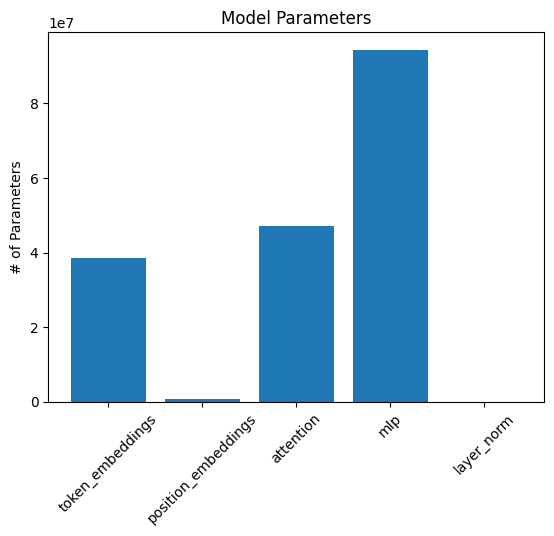

token_embeddings               38,598,144      21.33%
position_embeddings               786,432       0.43%
attention                      47,185,920      26.07%
mlp                            94,371,840      52.15%
layer_norm                         31,488       0.02%


Total parameters: 180,973,824


In [50]:
import matplotlib.pyplot as plt

parameter_counts = {
    "token_embeddings": vocabulary_size * embedding_dimensions,
    "position_embeddings": block_size * embedding_dimensions,
    "attention": (embedding_dimensions ** 2 + embedding_dimensions * 3 * embedding_dimensions) * num_hidden_layers,
    "mlp": embedding_dimensions * 4 * embedding_dimensions * 2 * num_hidden_layers,
    "layer_norm": embedding_dimensions * num_hidden_layers * 2 + embedding_dimensions,
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")

print("\n")

print(f"Total parameters: {total_parameter_count:,}")

Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training.

In [51]:
bytes_per_parameter = 32 // 8 # Assuming 32-bit floating point

buffers_per_parameter = 2 # Assuming AdamW optimizer

total_values = total_parameter_count + buffers_per_parameter * total_parameter_count

total_bytes_per_parameter = total_values * bytes_per_parameter

total_gigabytes = total_bytes_per_parameter / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}")

Total gigabytes: 2.17


Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the network on a single sample.

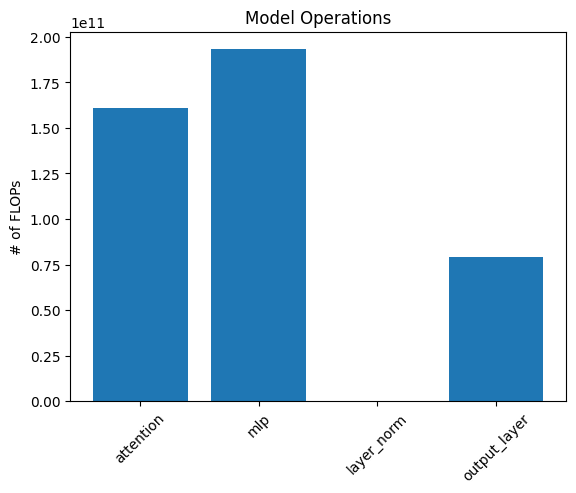

attention                 161,061,273,600      37.16%
mlp                       193,274,081,280      44.60%
layer_norm                         96,768       0.00%
output_layer               79,048,998,912      18.24%


Total forward FLOPs: 433,384,450,560


In [52]:
ops_per_matmul = 2 # Multiply + accumulate (MAC)
ops_per_activation = 9 # Assuming GELU
ops_per_layer_norm = 6 # Mean (1), variance (3), shift (1), scale (1)

# K, Q, V projections
attention = ops_per_matmul * block_size * embedding_dimensions * 3 * embedding_dimensions

# Attention logits
attention += 2 * ops_per_matmul * block_size ** 2 * embedding_dimensions

# Output projection
attention += ops_per_matmul * block_size * embedding_dimensions ** 2

attention *= num_hidden_layers

# Linear transformations
mlp = 2 * ops_per_matmul * block_size * embedding_dimensions * 4 * embedding_dimensions

# Non-linear activations
mlp += ops_per_activation * 4 * embedding_dimensions

mlp *= num_hidden_layers

layer_norm = ops_per_layer_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = ops_per_matmul * block_size * embedding_dimensions * vocabulary_size

flops = {
    "attention": attention,
    "mlp": mlp,
    "layer_norm": layer_norm,
    "output_layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2X the forward pass.

In [53]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 866,768,901,120
